## **[Week 10] Regularization**

* Motivation
* Implement regularization: $l_1$, $l_2$, dropout.

**[Important]** The results of the exercises should be included in your weekly report for this practice session. The weekly report for this session should be submitted to KLMS by this weekend. No late submission would be accepted.

###1. Motivation  
Regularizatoin technique is a strategy used to prevent overfitting, enhance model generalization, and improve its performance on unseen data.
In this part, we understand why we use regularization technique.  
We observe overfitting when we use a model with high complexity and observe mitigation of overffing when we use regularization.

In [30]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import torch.optim as optim
import random

# Set random seeds fixed for reproducibility
seed = 7    # Do NOT change the seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

Generate synthetic data

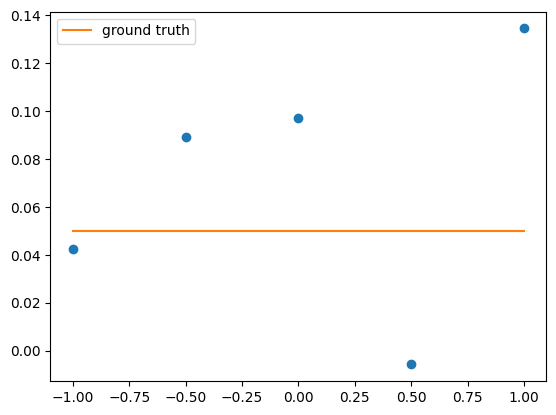

In [31]:
# synthetic data
# ground truth: y=0.05 for all x
X = torch.tensor([-1,-0.5,0,0.5,1])
y = torch.tensor([0.05,0.05,0.05,0.05,0.05])
noise = torch.randn(5)*0.05
y=y+noise
plt.plot(X,y,'o')

X_grid = torch.linspace(-1,1,201)
plt.plot(X_grid,[0.05]*len(X_grid),label='ground truth')
plt.legend()
plt.show()

Define fourth-order model

In [32]:
# high order polynomial model
class PolyRegression(nn.Module):
  def __init__(self):
    super(PolyRegression,self).__init__()
    self.theta = nn.Parameter(torch.zeros(5))

  def forward(self,x):
    return self.theta[0] + self.theta[1] * x + self.theta[2] * x**2 + self.theta[3] * x**3 + self.theta[4] * x**4

poly_model = PolyRegression()
poly_model.theta

Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)

Train the models

In [33]:
# loop
n_epochs = 2000

#optimizer
optP = optim.SGD(poly_model.parameters(),lr=0.3)

loss_list_P = list()

for e in range(n_epochs):
  predP = poly_model(X) #y_hat

  lossP = torch.sum((predP - y)**2)/len(X)
  loss_list_P.append(lossP.item())

  optP.zero_grad()
  lossP.backward()
  optP.step()

In [34]:
print("coefficients of polynomial model: ",poly_model.theta)

coefficients of polynomial model:  Parameter containing:
tensor([ 0.0961, -0.1420, -0.2831,  0.1880,  0.2755], requires_grad=True)


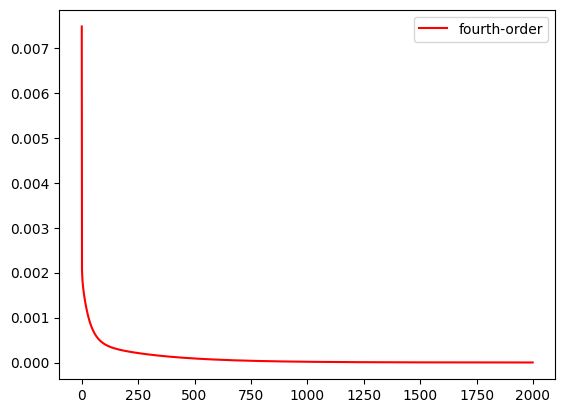

In [35]:
plt.plot(loss_list_P,'r',label='fourth-order')
plt.legend()
plt.show()

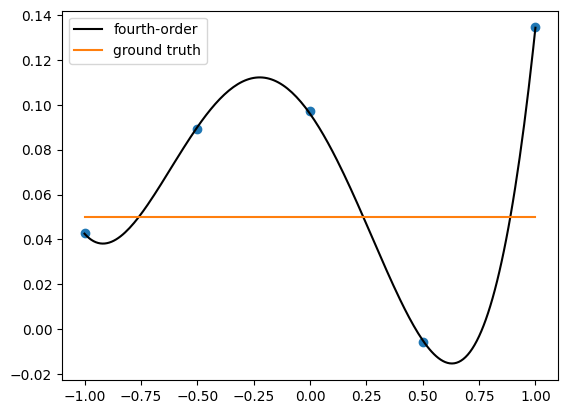

In [36]:
# five points
plt.plot(X,y,'o')

X_grid = torch.linspace(-1,1,201)

predP = [yhat.detach() for yhat in poly_model(X_grid)]
plt.plot(X_grid,predP,'k',label='fourth-order')

plt.plot(X_grid,[0.05]*len(X_grid),label='ground truth')
plt.legend()

plt.show()

Now, add $l_2$ regression  
Here, we don't explicitly design $l_2$ regularization but use argument "weight_decay" of optim.SGD.  
You will design $l_2$ regularization later.

In [8]:
poly_model_reg = PolyRegression()

In [9]:
# loop
n_epochs = 2000

#optimizer
optP_reg = optim.SGD(poly_model_reg.parameters(),lr=0.005,weight_decay=1)

loss_list_P_reg = list()

for e in range(n_epochs):
  predP_reg = poly_model_reg(X) #y_hat

  lossP_reg = torch.sum((predP_reg - y)**2)/len(X)
  loss_list_P_reg.append(lossP_reg.item())

  optP_reg.zero_grad()
  lossP_reg.backward()
  optP_reg.step()

In [10]:
poly_model_reg.theta

Parameter containing:
tensor([0.0382, 0.0017, 0.0153, 0.0169, 0.0155], requires_grad=True)

Compare the training loss curves for cases with and without regularization.

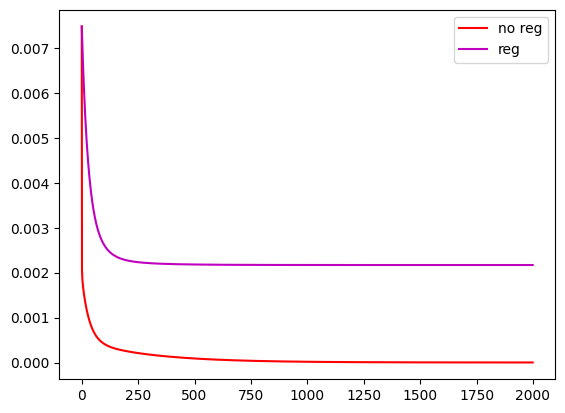

In [11]:
# Train loss
plt.plot(loss_list_P,'r',label='no reg')
plt.plot(loss_list_P_reg,'m',label='reg')
plt.legend()
plt.show()

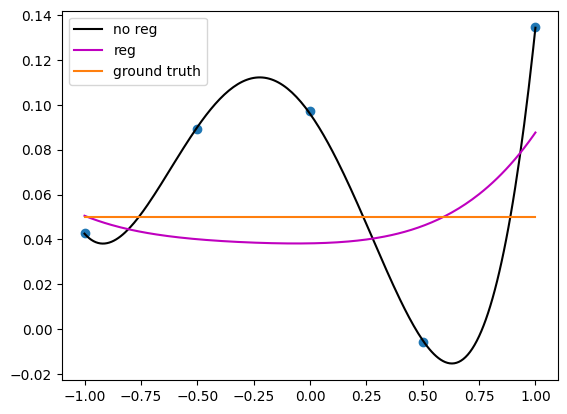

In [12]:
plt.plot(X,y,'o')

X_grid = torch.linspace(-1,1,201)

predP = [yhat.detach() for yhat in poly_model(X_grid)]
plt.plot(X_grid,predP,'k',label='no reg')
predP_reg = [yhat.detach() for yhat in poly_model_reg(X_grid)]
plt.plot(X_grid,predP_reg,'m',label='reg')

plt.plot(X_grid,[0.05]*len(X_grid),label='ground truth')
plt.legend()

plt.show()

###Remark  
Without regularization, model with high complexity has overfitted to the given dataset(black graph).   
By adding regularization, overfitting has mitigated(purple graph).  
This simple example illustrates the role that regularization techniques play.

###2. Implement regularization: $l_1,l_2$, dropout.  
We implement several regularization techniques with binary classification task.  
We practiced this task in the week 06 for regression.

#### 2-1. Recall binary classification with Titanic dataset

Import the required packages

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import pandas as pd
import requests
from io import StringIO
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Load and preprocess the Titanic dataset

In [14]:
# URL to the Titanic dataset
url = "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"

# Make a GET request to the URL and read the content into a pandas DataFrame
response = requests.get(url).text
data = pd.read_csv(StringIO(response))

In [15]:
# Preprocessing
data.dropna(subset=['Age', 'Fare'], inplace=True) # empty -> drop
X = data[['Pclass', 'Sex', 'Age', 'Fare']]
y = data['Survived']
X = pd.get_dummies(X, columns=['Pclass', 'Sex'], drop_first=True) # one-hot encoding
# drop the first to reduce complexity e.g. Pclass=3->001->00, Pclass=1->100->00, male->1, female->0

To observe the effect of regularization, we try an extreme case where the size of training dataset is small.

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# check the size of training dataset
len(X_train)

44

In [18]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32) #, requires_grad=True)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32) #, requires_grad=True)
y_train_tensor = y_train.astype(float)
y_test_tensor = y_test.astype(float)
y_train_tensor = torch.tensor(y_train_tensor.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_tensor.values, dtype=torch.long)

Define classificaiton model

**Exercise 1.**  
Define functions **compute_l1_norm** and **compute_l2_norm**.  
* input: flattened vector
* output: $l_1$-norm and $l_2$-norm, respectively.

In [19]:
class NN(nn.Module):
  def __init__(self):
    super(NN,self).__init__()
    self.fc1 = nn.Linear(5,16)
    self.fc2 = nn.Linear(16,8)
    self.fc3 = nn.Linear(8,1)

  def forward(self,x):
    x = self.fc1(x)
    x = nn.ReLU()(x)
    x = self.fc2(x)
    x = nn.ReLU()(x)
    x = self.fc3(x)
    return x

  def compute_l1_norm(self, w):
    ####### Task 1 #######
    return sum(abs(i) for i in w)
    ######################

  def compute_l2_norm(self, w):
    ####### Task 1 #######
    return sum((i**2) for i in w)
    ######################

#### 2-2. Classification with no regularization

Define model, loss and optimizer.  
Run the main loop without regularization.

In [20]:
# No regularization

regmodel=NN() #regression model
regmodel.to(torch.float32)

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Create an optimizer
#optimizer = optim.SGD(regmodel.parameters(), lr=0.01)
optimizer = optim.Adam(regmodel.parameters(), lr=0.01)

num_epochs = 3000

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero the gradients

    out = regmodel(X_train_tensor)                     # Forward pass
    p=torch.cat((torch.zeros_like(out),out),dim=1)     # binary probability distribution
    loss = criterion(p, y_train_tensor)                # Compute the loss

    loss.backward()        # Backpropagate to compute gradients
    optimizer.step()       # Update the model's parameters

Test your model

In [21]:
regmodel.eval()
with torch.no_grad():
  # Predictions
  y_pred = regmodel(X_test_tensor)
  y_pred = [y.detach().numpy()>=0 for y in y_pred]

  # Convert true labels tensor to numpy array
  y_test_np = y_test_tensor.numpy()

  # Evaluate the model
  accuracy = accuracy_score(y_test_np, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6963226571767497


#### 2-3. $l_1$ regularization    
Let the loss function without regularization be denoted as $L(\theta)$.  
In this part, you will implement $l_1$ regularization: $L_{1}(\theta)=L(\theta)+\lambda\Sigma_i|\theta_i|$

Define model, loss and optimizer.  
Run the main loop with $l_1$ regularization.

**Exercise 2.**  
Define the loss function with $l_1$-regularization.  
Use **compute_l1_norm** method.

In [22]:
# l1 regularization
l1_lambda = 5e-4

regmodel_l1=NN() #regression model
regmodel_l1.to(torch.float32)

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Create an optimizer
#optimizer = optim.SGD(regmodel_l1.parameters(), lr=0.01)
optimizer = optim.Adam(regmodel_l1.parameters(), lr=0.01)

num_epochs = 3000

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero the gradients

    out = regmodel_l1(X_train_tensor)                     # Forward pass
    p=torch.cat((torch.zeros_like(out),out),dim=1)     # binary probability distribution
    loss = criterion(p, y_train_tensor)                # Compute the loss

    params = []
    for param in regmodel_l1.parameters():
        params.append(param.view(-1))

    ####### Task 2 ######
    ### Add proper regularization term using the method "compute_l1_norm" ###
    reg = regmodel_l1.compute_l1_norm(torch.cat(params))
    loss += l1_lambda*reg

    #####################

    loss.backward()        # Backpropagate to compute gradients
    optimizer.step()       # Update the model's parameters

Test your model

In [23]:
regmodel_l1.eval()
with torch.no_grad():
  # Predictions
  y_pred = regmodel_l1(X_test_tensor)
  y_pred = [y.detach().numpy()>=0 for y in y_pred]

  # Convert true labels tensor to numpy array
  y_test_np = y_test_tensor.numpy()

  # Evaluate the model
  accuracy = accuracy_score(y_test_np, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7236061684460261


#### 2-4. $l_2$ regularization  
In this part, you will implement $l_2$ regularization: $L_{2}(\theta)=L(\theta)+\frac{\lambda}{2}\Sigma_i\theta_i^2$

Define model, loss and optimizer.  
Run the main loop with $l_2$ regularization.

**Exercise 3.**   
Define the loss function with $l_2$-regularization.  
Use **compute_l2_norm** method.

In [24]:
# l2 regularization
l2_lambda = 5e-4

regmodel_l2=NN() #regression model
regmodel_l2.to(torch.float32)

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Create an optimizer
#optimizer = optim.SGD(regmodel_l2.parameters(), lr=0.01)
optimizer = optim.Adam(regmodel_l2.parameters(), lr=0.01)

num_epochs = 3000

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero the gradients

    out = regmodel_l2(X_train_tensor)                     # Forward pass
    p=torch.cat((torch.zeros_like(out),out),dim=1)     # binary probability distribution
    loss = criterion(p, y_train_tensor)                # Compute the loss

    params = []
    for param in regmodel_l2.parameters():
        params.append(param.view(-1))

    ####### Task 3 ######
    ### Add proper regularization term using the method "compute_l2_norm" ###
    reg = regmodel_l2.compute_l2_norm(torch.cat(params))
    loss += l2_lambda*reg*0.5

    #####################

    loss.backward()        # Backpropagate to compute gradients
    optimizer.step()       # Update the model's parameters

Test your model

In [25]:
regmodel_l2.eval()
with torch.no_grad():
  # Predictions
  y_pred = regmodel_l2(X_test_tensor)
  y_pred = [y.detach().numpy()>=0 for y in y_pred]

  # Convert true labels tensor to numpy array
  y_test_np = y_test_tensor.numpy()

  # Evaluate the model
  accuracy = accuracy_score(y_test_np, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7069988137603797


#### Remark for $l_2$ regularization  
Recall the loss $L_{2}(\theta)=L(\theta)+\frac{\lambda}{2}\Sigma_i\theta_i^2$. By taking derivative, obtain  
\begin{align}
    \nabla_\theta L_2(\theta) = \nabla_\theta L(\theta) + \lambda\theta
\end{align}
Applying gradient descent step for $L_2$, update rule becomes
\begin{align}
    \theta \leftarrow &\theta-\alpha(\nabla_\theta L(\theta) + \lambda\theta)\\
    =&(1-\alpha\lambda)\theta-\alpha\nabla_\theta L(\theta)
\end{align}
which can be interpreted as gradient descent for loss $L$ with decaying the current $\theta$.  
This is why the hyperparameter $\lambda$ is usually called "weight decay". (weight $\theta$ is decayed by factor $1-\alpha\lambda$)

#### 2-5. Dropout

* Dropout is a regularization technique for neural networks to mitigate overfitting.   
* Dropout rate $p\in[0,1]$ indicates the proportion of neurons to be dropped out.  
 In other words, each neuron in dropout layer with rate $p$ is dropped out with probability $p$.
* Dropout prevents any single neuron from relying too heavily on specific input features. Therefore, the model can learn more diverse and generalized representations.  
* When implementing dropout, the size of input is not changed but some neurons are set to 0.  


<a href="https://imgbb.com/"><img src="https://i.ibb.co/C9sJbyk/dropout.png" alt="dropout" border="0"></a>  
image source - Dropout: A Simple Way to Prevent Neural Networks from
Overfitting

**Exercise 4.**   
Design your own network with dropout.  
Dropout rate does not have to be 0.5.  
You can add dropout layers wherever you want.   
The only requirement is that you must use dropout at least once.

In [26]:
class NN_Dropout(nn.Module):
  def __init__(self):
    super(NN_Dropout,self).__init__()
    self.fc1 = nn.Linear(5,16)
    self.fc2 = nn.Linear(16,8)
    self.fc3 = nn.Linear(8,1)
    self.dropout = nn.Dropout(0.5) # You can change the dropout rate

  def forward(self,x):
    ###### Task 4 #######
    x = self.fc1(x)
    x = nn.ReLU()(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = nn.ReLU()(x)
    x = self.dropout(x)
    x = self.fc3(x)

    #####################
    return x

Define model, loss and optimizer.  
Run the main loop with dropout.

In [27]:
# Dropout regularization

regmodel_dropout=NN_Dropout() #regression model
regmodel_dropout.to(torch.float32)

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Create an optimizer
#optimizer = optim.SGD(regmodel_dropout.parameters(), lr=0.01)
optimizer = optim.Adam(regmodel_dropout.parameters(), lr=0.01)

num_epochs = 3000


# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero the gradients

    out = regmodel_dropout(X_train_tensor)                     # Forward pass
    p=torch.cat((torch.zeros_like(out),out),dim=1)     # binary probability distribution
    loss = criterion(p, y_train_tensor)                # Compute the loss

    loss.backward()        # Backpropagate to compute gradients
    optimizer.step()       # Update the model's parameters

Test your model

In [28]:
regmodel_dropout.eval()
with torch.no_grad():
  # Predictions
  y_pred = regmodel_dropout(X_test_tensor)
  y_pred = [y.detach().numpy()>=0 for y in y_pred]

  # Convert true labels tensor to numpy array
  y_test_np = y_test_tensor.numpy()

  # Evaluate the model
  accuracy = accuracy_score(y_test_np, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7876631079478055


##Reference  
https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-pytorch.md